# Estimating ancestry

If samples in the reference haplotype panel are labeled with a population origin, MendelImpute can also be used for:

+ Estimate admixed proportions
+ Chromosome painting

In [1]:
# first load all necessary packages
using MendelImpute
using VCFTools
using GeneticVariation
using Random
using DataFrames
using Plots
using JLSO
using CSV

## Data preparation

### Step 1. Filter chromosome data 

We use the [1000 genomes chromosome 22](http://bochet.gcc.biostat.washington.edu/beagle/1000_Genomes_phase3_v5a/b37.vcf/) as illustration.  The original data is filtered into target and reference panels. Follow [detailed example](https://openmendel.github.io/MendelImpute.jl/dev/man/Phasing+and+Imputation/#Detailed-Example) in Phasing and Imputation to obtain the same data.


!!! note

    In practice, it is better to infer ancestry of admixed populations using non-admixed reference populations. The example here is a simplified illustration and should not be taken too literally. 



### Step 2. Process each sample's population origin

The goal is to create a `Dict{key, value}` where each key is a sample ID and the value is the population code. This will be used for both the [paint](https://openmendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.paint) and [composition](https://openmendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.composition) function.

In [2]:
# read population origin into a dataframe
file = joinpath(normpath(MendelImpute.datadir()), "1000genomes.population.txt")
df = CSV.read(file)

# create dictionary with key = ID, value = population 
refID_to_population = Dict{String, String}()
for (id, population) in eachrow(df)
     refID_to_population[id] = population
end
refID_to_population

Dict{String,String} with 2504 entries:
  "HG01791" => "GBR"
  "HG02736" => "PJL"
  "HG00182" => "FIN"
  "HG03914" => "BEB"
  "HG00149" => "GBR"
  "NA12156" => "CEU"
  "HG02642" => "GWD"
  "HG02851" => "GWD"
  "NA19835" => "ASW"
  "NA19019" => "LWK"
  "HG01131" => "CLM"
  "HG03578" => "MSL"
  "NA18550" => "CHB"
  "HG02401" => "CDX"
  "HG01350" => "CLM"
  "HG03973" => "ITU"
  "NA07000" => "CEU"
  "HG01709" => "IBS"
  "HG01395" => "PUR"
  "HG01980" => "PEL"
  "HG01979" => "PEL"
  "HG01122" => "CLM"
  "HG03869" => "ITU"
  "HG03729" => "ITU"
  "NA19920" => "ASW"
  ⋮         => ⋮

Note the [population codes](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/) for 1000 genome's samples are explained [here](https://www.internationalgenome.org/category/population/). 

### Step 3. Compute phase information using MendelImpute

This is equivalent to running a typical imputation. Please ensure that:
+ The output file name ends with `.jlso` (save output to ultra-compressed format)
+ `impute = true` (so the output contains the entire chromosome)

Note data used here is prepared in [Detailed Example](https://openmendel.github.io/MendelImpute.jl/dev/man/Phasing+and+Imputation/#Detailed-Example).

In [3]:
# compute each person's phase information
tgtfile = "target.chr22.typedOnly.masked.vcf.gz"
reffile = "ref.chr22.maxd1000.excludeTarget.jlso"
outfile = "mendel.imputed.jlso"
@time ph = phase(tgtfile, reffile, outfile);

Number of threads = 1
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:22
Phasing...100%|█████████████████████████████████████████| Time: 0:00:05


Total windows = 1634, averaging ~ 508 unique haplotypes per window.

Timings: 
    Data import                     = 12.7096 seconds
        import target data             = 3.12892 seconds
        import compressed haplotypes   = 9.58064 seconds
    Computing haplotype pair        = 23.0121 seconds
        BLAS3 mul! to get M and N      = 1.01843 seconds per thread
        haplopair search               = 18.2076 seconds per thread
        initializing missing           = 0.0986759 seconds per thread
        allocating and viewing         = 0.281521 seconds per thread
        index conversion               = 0.0112288 seconds per thread
    Phasing by win-win intersection = 5.48517 seconds
        Window-by-window intersection  = 0.52932 seconds per thread
        Breakpoint search              = 3.76968 seconds per thread
        Recording result               = 0.138674 seconds per thread
    Imputation                     = 3.11584 seconds
        Imputing missing               = 0

## Estimate admixture proportions

The [composition](https://openmendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.composition) will compute a list of percentages where `composition[i]` equals the sample's ancestry (in %) from `populations[i]`. Thus we simply have to plot the result. This illustration depends on **data preparation** above. 

### Step 1: import necessary data

In [4]:
# First import compressed reference panel
reffile = "ref.chr22.maxd1000.excludeTarget.jlso"
compressed_Hunique = JLSO.load(reffile)[:compressed_Hunique]
panelID = compressed_Hunique.sampleID

# also need target sample's ancestry
tgtfile = "target.chr22.typedOnly.masked.vcf.gz"
reader = VCF.Reader(openvcf(tgtfile, "r"))
tgtID  = VCF.header(reader).sampleID
sample_population = [refID_to_population[id] for id in tgtID];

In [5]:
# here is our sample population (sample 1 is GBR, 4 is CHS, 84 is LWK...etc)
sample_population

100-element Array{String,1}:
 "GBR"
 "FIN"
 "CHS"
 "CHS"
 "CDX"
 "CDX"
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 "GBR"
 "CLM"
 "IBS"
 ⋮
 "MXL"
 "ASW"
 "ASW"
 "TSI"
 "TSI"
 "TSI"
 "TSI"
 "TSI"
 "TSI"
 "TSI"
 "GIH"
 "GIH"

### Step 2: call `composition` function

The [composition](https://openmendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.composition) will compute a list of percentages where `composition[i]` equals the sample's ancestry (in %) from `populations[i]`. We are finally using the imputation result stored in `ph`.

In [7]:
populations = MendelImpute.unique_populations(refID_to_population)
@time sample1_comp = composition(ph[1], panelID, refID_to_population) # origin GBR
@time sample4_comp = composition(ph[4], panelID, refID_to_population) # origin CHS
@time sample84_comp = composition(ph[84], panelID, refID_to_population) # origin LWK

  0.004058 seconds (28 allocations: 2.719 KiB)
  0.000344 seconds (8 allocations: 1.250 KiB)
  0.000341 seconds (8 allocations: 1.250 KiB)


26-element Array{Float64,1}:
 0.031664555855883895
 0.004281873442329377
 0.0183269450383178
 0.0025138200248509064
 0.0014987155576730166
 0.1175713625622769
 0.0104802353893189
 0.21298280307691572
 0.0338623527918964
 0.07203411134068007
 0.0002681408026507634
 0.004550014244980141
 0.004151394212468068
 0.013386690160908423
 0.06359485840010917
 0.006903428611102466
 0.0006188785489751994
 0.1910251836884204
 0.016276386132332274
 0.06281796830671477
 0.0004357288043074905
 0.003690527207912069
 0.11686150766954519
 0.006875896296544575
 0.0028884989142691606
 0.0004381229186168723

We computed the population percentages for sample 1, 4, and 84 with respect to the 26 reference populations. Note the first run is slower because Julia has to compile the code. 

### Step 3: Plot the percentages

Here `sample1_comp[i]` equals the sample's estimated ancestry (in %) from `populations[i]`. Thus we simply have to create a bar plot for each:

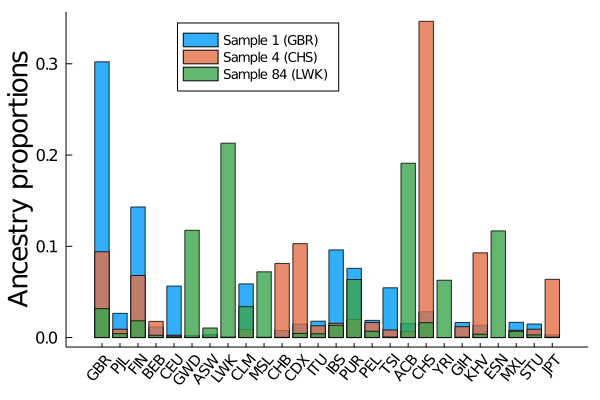

In [8]:
barplot = bar(sample1_comp, xticks=(1:1:26, populations), xrotation=50, grid=false, 
    ylabel = "Ancestry proportions", label="Sample 1 (GBR)", alpha=0.8, legend=:top,
    xtickfont=font(10), ytickfont=font(11), legendfont=font(9), yguidefontsize=18)
bar!(barplot, sample4_comp, label="Sample 4 (CHS)", alpha=0.8)
bar!(barplot, sample84_comp, label="Sample 84 (LWK)", alpha=0.8)

**Conclusion:** From the bar plot, sample 1 (GBR) is 30\% GBR, 15\% FIN, 10\% IBS...etc. Sample 4 (CHS) is 40\% CHS, 10\% CDX,...etc. Sample 84 is 25\% LWK, 20\% ACB,...etc. 

## Chromosome painting

The main function is the [paint](https://openmendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.paint) function. For an imputed sample, it will convert **each haplotype segment** into a percentage indicating the segment's length in the chromosome. Then the list can be used for easy plotting. 

**Note:** this illustration depends on **data preparation** above. 

### Step 1: Choose your colors

In this example, colors are arranged such that:
+ Blue ≈ European/American
+ Red ≈ Asian
+ Green ≈ African

Of course, Julia lets you plot your favoriate colors. We pick our colors here: https://mdigi.tools/color-shades/#008000.

In [9]:
# generated here: https://mdigi.tools/color-shades/#008000
# Blue ≈ European/American, Red ≈ Asian, Green ≈ Africa
goodcolors = [colorant"#c8c8ff", colorant"#ffeaea", colorant"#ffbfbf", colorant"#a4a4ff",
    colorant"#8080ff", colorant"#e3ffe3", colorant"#aaffaa", colorant"#71ff71", 
    colorant"#5b5bff", colorant"#ff9595", colorant"#39ff39", colorant"#ff6a6a",
    colorant"#ff4040", colorant"#3737ff", colorant"#1212ff", colorant"#0000c8", 
    colorant"#0000a4", colorant"#00ff00", colorant"#ff1515", colorant"#00c600", 
    colorant"#ea0000", colorant"#bf0000", colorant"#008e00", colorant"#00005b",
    colorant"#950000", colorant"#6a0000"]

### Step 2: Run `paint` funcion

This function convert the imputed haplotype segments into a list of percentages (one list for each strand). This is simply a post-processing routine so that data can be used for easy plotting later.

In [10]:
populations = unique_populations(refID_to_population)
@time sample1_s1_comp, sample1_s2_comp = paint(ph[1], panelID, refID_to_population)
@time sample4_s1_comp, sample4_s2_comp = paint(ph[4], panelID, refID_to_population)
@time sample84_s1_comp, sample84_s2_comp = paint(ph[84], panelID, refID_to_population);

  0.000263 seconds (12 allocations: 19.125 KiB)
  0.000252 seconds (12 allocations: 20.375 KiB)
  0.000269 seconds (12 allocations: 22.875 KiB)


### Step 3: Generate plots for painted chromosomes

We found the [StatsPlots.jl](https://github.com/JuliaPlots/StatsPlots.jl) package to be more useful for this purpose, although the code below still did the plotting in a very roundabout way. 

In [11]:
# assign a color to each haplotype segment
sample1_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample1_s1_comp[2]]
sample1_s1_colors = reshape(sample1_s1_colors, 1, length(sample1_s1_colors))

sample1_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample1_s2_comp[2]]
sample1_s2_colors = reshape(sample1_s2_colors, 1, length(sample1_s2_colors))

sample4_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample4_s1_comp[2]]
sample4_s1_colors = reshape(sample4_s1_colors, 1, length(sample4_s1_colors))

sample4_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample4_s2_comp[2]]
sample4_s2_colors = reshape(sample4_s2_colors, 1, length(sample4_s2_colors))

sample84_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample84_s1_comp[2]]
sample84_s1_colors = reshape(sample84_s1_colors, 1, length(sample84_s1_colors))

sample84_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample84_s2_comp[2]]
sample84_s2_colors = reshape(sample84_s2_colors, 1, length(sample84_s2_colors));

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278


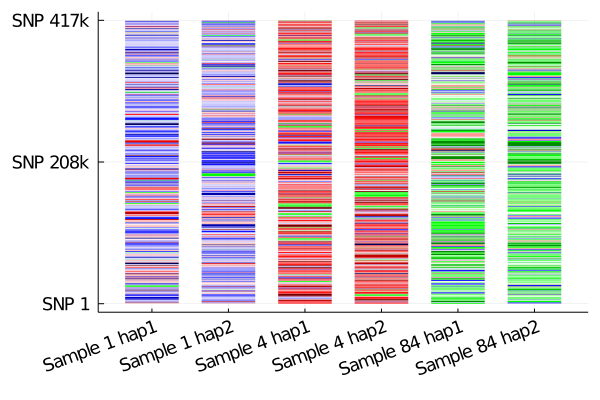

In [12]:
using StatsPlots, FixedPointNumbers

# some tedious and roundabout routine for making a bad groupedplot
sample1_s1l = length(sample1_s1_comp[1])
sample1_s2l = length(sample1_s2_comp[1])
sample4_s1l = length(sample4_s1_comp[1])
sample4_s2l = length(sample4_s2_comp[1])
sample84_s1l = length(sample84_s1_comp[1])
sample84_s2l = length(sample84_s2_comp[1])
maxlen = max(sample1_s1l, sample1_s2l, sample4_s1l, sample4_s2l, sample84_s1l, sample84_s2l)

mydata = zeros(6, maxlen)
copyto!(@view(mydata[1, 1:sample1_s1l]), sample1_s1_comp[1])
copyto!(@view(mydata[2, 1:sample1_s2l]), sample1_s2_comp[1])
copyto!(@view(mydata[3, 1:sample4_s1l]), sample4_s1_comp[1])
copyto!(@view(mydata[4, 1:sample4_s2l]), sample4_s2_comp[1])
copyto!(@view(mydata[5, 1:sample84_s1l]), sample84_s1_comp[1])
copyto!(@view(mydata[6, 1:sample84_s2l]), sample84_s2_comp[1])

mycolors = Matrix{RGB{Normed{UInt8,8}}}(undef, 6, maxlen)
copyto!(@view(mycolors[1, 1:sample1_s1l]), sample1_s1_colors)
copyto!(@view(mycolors[2, 1:sample1_s2l]), sample1_s2_colors)
copyto!(@view(mycolors[3, 1:sample4_s1l]), sample4_s1_colors)
copyto!(@view(mycolors[4, 1:sample4_s2l]), sample4_s2_colors)
copyto!(@view(mycolors[5, 1:sample84_s1l]), sample84_s1_colors)
copyto!(@view(mycolors[6, 1:sample84_s2l]), sample84_s2_colors)

# axis labels
xnames = ["Sample 1 hap1", "Sample 1 hap2", "Sample 4 hap1", "Sample 4 hap2", "Sample 84 hap1", "Sample 84 hap2"]
ynames = ["SNP 1", "SNP 208k", "SNP 417k"]

# final plot
chrom_plt = groupedbar(mydata, bar_position = :stack, bar_width=0.7, label=:none, 
    lw = 0, color=mycolors, xticks=(1:1:6, xnames), yticks=(0:0.5:1, ynames),
    ytickfont=font(12), xtickfont=font(12), xrotation=20)

For more details, please refer to our paper, or file an issue on GitHub. 